# 6. VGG16 (Pre-trained CNN model with Fine Tunning)

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [1]:
from keras.applications import vgg16
from keras.models import Model
import keras
import os,shutil,math,scipy,cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import pandas as pd

Using TensorFlow backend.


In [2]:
def redo_kreas_category(arr):
    redo=[]
    for i in arr:
        redo.append(list(i).index(1))
    return redo

- Get the data

In [3]:
lists=pd.read_csv('categories.csv')
lists=list(lists['0'])
len(lists)

60

In [4]:
true_labels = []
imgsize=100
#result_array = np.zeros((20580, imgsize, imgsize, 3))
result_array = np.zeros((11386, imgsize, imgsize, 3))
cur_dir = os.path.dirname(os.path.realpath(os.getcwd()))
paths=cur_dir+'/Project/Images/'
# we have 20580 images


j=0
for i in lists:
    images=os.listdir(paths+i)
    label=i[10:]
    for k in images:
        img = cv2.imread(paths+i+'/'+k,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        true_labels.append(label)
        result_array[j,:,:,:]=np.array(img)
        j=j+1

In [5]:
result_array.shape

(11386, 100, 100, 3)

- Train test split & encode y labels

In [6]:
le = LabelEncoder()
le.fit(true_labels)
all_labels_enc = le.transform(true_labels)
all_labels_enc = to_categorical(all_labels_enc,len(np.array(np.unique(true_labels))))

print(true_labels[0:10], all_labels_enc[0:10])

['Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog', 'Maltese_dog'] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0

In [7]:
X = result_array/255

X_train, X_test, y_train, y_test = train_test_split(X,all_labels_enc,test_size=0.2,random_state=69)
X_train, X_val, y_train, y_val  = train_test_split(X_train,y_train,test_size=0.2,random_state=69)

- Modeling

In [8]:
input_shape = (imgsize, imgsize, 3)

In [9]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [11]:
batch_size = 30 #number of images passed to the operation in every iteration
num_classes = len(np.array(np.unique(true_labels))) # target class
epochs = 30  #30 #number of times the entire dataset has gone through the neural network

In [17]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.array(np.unique(true_labels))), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
    
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

#history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=20,
#                              validation_data=val_generator, validation_steps=50, 
#                              verbose=1)              

Instructions for updating:
Use tf.cast instead.
Train on 7286 samples, validate on 1822 samples
Epoch 1/30
7286/7286 [==============================] - 1439s 197ms/step - loss: 4.1176 - acc: 0.0166 - val_loss: 4.0938 - val_acc: 0.0203
Epoch 2/30
7286/7286 [==============================] - 1430s 196ms/step - loss: 4.0950 - acc: 0.0225 - val_loss: 4.0942 - val_acc: 0.0220
Epoch 3/30
7286/7286 [==============================] - 1426s 196ms/step - loss: 4.0943 - acc: 0.0225 - val_loss: 4.0941 - val_acc: 0.0220
Epoch 4/30
7286/7286 [==============================] - 1425s 196ms/step - loss: 4.0939 - acc: 0.0242 - val_loss: 4.0940 - val_acc: 0.0220
Epoch 5/30
7286/7286 [==============================] - 1427s 196ms/step - loss: 4.0938 - acc: 0.0211 - val_loss: 4.0938 - val_acc: 0.0220
Epoch 6/30
7286/7286 [==============================] - 1432s 197ms/step - loss: 4.0936 - acc: 0.0235 - val_loss: 4.0937 - val_acc: 0.0220
Epoch 7/30
7286/7286 [==============================] - 1428s 196ms/st

- See accuracy in test dataset & double check other accuracies

In [18]:
# test
#train_features_vgg = get_bottleneck_features(vgg_model, X_train)
#validation_features_vgg = get_bottleneck_features(vgg_model, X_val)
#test_features_vgg = get_bottleneck_features(vgg_model, X_test)

y_test_model = model.predict_classes(X_test)
y_test_model_prob=model.predict_proba(X_test)
print(y_test_model_prob.shape)
y_test_true_flat=redo_kreas_category(y_test)
print(np.unique(y_test_model))
print(accuracy_score(y_test_model, y_test_true_flat))

(2278, 60)
[26]
0.01887620719929763


In [19]:
# validation
y_val_model = model.predict_classes(X_val)
y_val_model_prob=model.predict_proba(X_val)
print(y_val_model_prob.shape)
y_val_true_flat=redo_kreas_category(y_val)
print(np.unique(y_val_model))
print(accuracy_score(y_val_model, y_val_true_flat))

(1822, 60)
[26]
0.021953896816684963


In [20]:
# train
y_train_model = model.predict_classes(X_train)
y_train_model_prob=model.predict_proba(X_train)
print(y_train_model_prob.shape)
y_train_true_flat=redo_kreas_category(y_train)
print(np.unique(y_train_model))
print(accuracy_score(y_train_model, y_train_true_flat))

(7286, 60)
[26]
0.02319516881690914


- Graphs

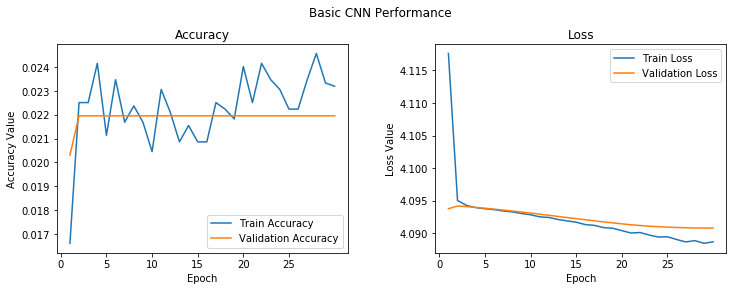

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,len(history.history['acc'])+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Overfitting?